# TMVA Classification 

This notebook is a basic example for training and testing CNN model with TMVA and TMVA-Keras.

(Based on TMVA Tutorials: https://github.com/lmoneta/tmva-tutorial)

## Declare Factory class

In [1]:
import ROOT
from ROOT import TMVA
from subprocess import call
import os 

Welcome to JupyROOT 6.21/01


In [2]:
ROOT.TMVA.Tools.Instance()
TMVA.PyMethodBase.PyInitialize()

## For PYMVA methods
TMVA.PyMethodBase.PyInitialize();


outputFile = ROOT.TFile.Open("CNN_ClassificationOutput.root", "RECREATE")

factory = ROOT.TMVA.Factory("TMVA_CNN_Classification", outputFile,
                      "!V:ROC:Silent:Color:!DrawProgressBar:AnalysisType=Classification" )

## Declare DataLoader(s)

Next we get the data and declare the DataLoader class.

In this case the input data consists of an image of 32x32 pixels. Each ROOT TTree contains a single branch containg a vector of size 1024 denoting the image pixels.

In [3]:
# Load data
inputFileName = "sample_images_32x32.root"

if not os.path.isfile(inputFileName):
    call(['curl', '-o', inputFileName, 'https://cernbox.cern.ch/index.php/s/mba2sFJ3ugoy269/download'])

In [4]:
inputFile = ROOT.TFile.Open( inputFileName )

# retrieve input trees
signalTree     = inputFile.Get("sig_tree")
backgroundTree = inputFile.Get("bkg_tree")

signalTree.Print()

******************************************************************************
*Tree    :sig_tree  : signal_tree                                            *
*Entries :    10000 : Total =        41219997 bytes  File  Size =   37110195 *
*        :          : Tree compression factor =   1.11                       *
******************************************************************************
*Br    0 :vars      : vector<float>                                          *
*Entries :    10000 : Total  Size=   41219579 bytes  File Size  =   37100381 *
*Baskets :     1158 : Basket Size=    3265024 bytes  Compression=   1.11     *
*............................................................................*


In [5]:
dataloader = TMVA.DataLoader('dataset')

### Adding the trees
dataloader.AddSignalTree(signalTree, 1.0)
dataloader.AddBackgroundTree(backgroundTree, 1.0)

# Add variables
imgsize = 32 * 32
for i in range(imgsize):
    varName = "var_{} := vars[{}]".format(i,i)
    dataloader.AddVariable(varName,'F')

dataloader.PrepareTrainingAndTestTree( ROOT.TCut(''), ROOT.TCut(''),
                                  "nTrain_Signal=8000:nTrain_Background=8000:SplitMode=Random:"
                                   "NormMode=NumEvents:!V" )

create data set info dataset


# Booking Methods

Here we book the TMVA and TMVA-Keras methods.

### Book Convolutional Neural Network in TMVA

In [6]:
#input layout 
inputLayoutString = "InputLayout=1|32|32"
                                                                           
## Batch Layout                                                                                                                                     
batchLayoutString = "BatchLayout=64|1|1024"
                                                   
layoutString = ("Layout=CONV|8|3|3|1|1|1|1|RELU,BNORM,CONV|8|3|3|1|1|1|1|RELU,"
                "BNORM,RESHAPE|FLAT,DENSE|64|TANH,DENSE|1|TANH")

##Training strategies.                                                                                                                          
training1 = ("LearningRate=0.0003,Momentum=0.9,Repetitions=1,"
                     "ConvergenceSteps=10,BatchSize=64,TestRepetitions=1,"
                     "MaxEpochs=20,WeightDecay=1e-4,Regularization=None,"
                     "Optimizer=SGD,DropConfig=0.0+0.0+0.0+0.0")
 
trainingStrategyString = "TrainingStrategy=" + training1
    
## General Options.                                                                                                                              
cnnOptions = ("!H:V:ErrorStrategy=CROSSENTROPY:VarTransform=None:"
                       "WeightInitialization=XAVIERUNIFORM")

cnnOptions +=  ":" + inputLayoutString
cnnOptions +=  ":" + batchLayoutString
cnnOptions +=  ":" + layoutString
cnnOptions +=  ":" + trainingStrategyString
cnnOptions +=  ":Architecture=CPU"

##book CNN
factory.BookMethod(dataloader, TMVA.Types.kDL, "DL_CNN", cnnOptions)

### Book Convolutional Neural Network in Keras

In [7]:
## to use tensorflow backend
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras import backend as K

from keras.regularizers import l2
from keras.optimizers import SGD

Using TensorFlow backend.


In [9]:
# Generate model
batch_size = 64
num_classes = 2
epochs = 20

# Define model
model = Sequential()
model.add(Reshape((32, 32, 1), input_shape=(imgsize,)))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))

# Set loss and optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=0.0003, decay=1e-6, momentum=0.9),
              metrics=['accuracy'])

# Store model to file
model.save('model_cnn.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 8)         80        
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 8)         32        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 8)         584       
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 8)         32        
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)               

2020-03-17 21:41:48.283480: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2020-03-17 21:41:48.293204: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2208000000 Hz
2020-03-17 21:41:48.295060: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fffc4711680 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-03-17 21:41:48.295165: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2020-03-17 21:41:48.295592: I tensorflow/core/common_runtime/process_util.cc:147] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [10]:
# Book method
factory.BookMethod(dataloader, TMVA.Types.kPyKeras, 'PyKeras',
                   'H:!V:VarTransform=None:FilenameModel=model_cnn.h5:'
                   'FileNameTrainedModel=trained_model_cnn.h5:NumEpochs={}:BatchSize={}'.format(epochs, batch_size))

2020-03-17 21:41:48.439258: I tensorflow/core/common_runtime/process_util.cc:147] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


## Train Methods

In [11]:
factory.TrainAllMethods()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 8)         80        
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 8)         32        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 8)         584       
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 8)         32        
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)               

## Test and Evaluate Methods

In [12]:
factory.TestAllMethods()

addBNormLayer 8 , 32 , 32 , 8  1024  100
addBNormLayer 8 , 32 , 32 , 8  1024  100


In [13]:
factory.EvaluateAllMethods()

addBNormLayer 8 , 32 , 32 , 8  1024  100
addBNormLayer 8 , 32 , 32 , 8  1024  100
                         : 
                         : Evaluation results ranked by best signal efficiency and purity (area)
                         : -------------------------------------------------------------------------------------------------------------------
                         : DataSet       MVA                       
                         : Name:         Method:          ROC-integ
                         : dataset       PyKeras        : 1.000
                         : dataset       DL_CNN         : 1.000
                         : -------------------------------------------------------------------------------------------------------------------
                         : 
                         : Testing efficiency compared to training efficiency (overtraining check)
                         : -----------------------------------------------------------------------------------------

## Plot ROC Curve

We plot here the produce ROC curve obtained on evaluating the methods on the test data set

In [14]:
# //We enable JavaScript visualisation for the plots
# %jsroot on

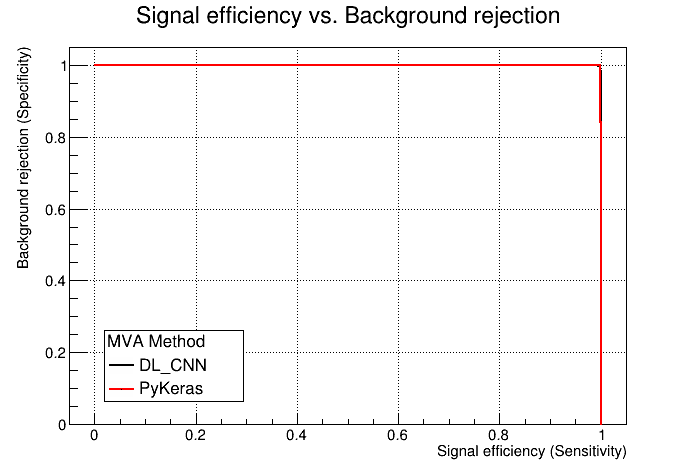

In [15]:
c1 = factory.GetROCCurve(dataloader);
c1.Draw();

####  Close outputfile to save all output information (evaluation result of methods)

In [16]:
outputFile.Close();